In [640]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from os import listdir
import matplotlib.patches as patches
from PIL import Image
from skimage.draw import line_aa
from mpl_toolkits.axes_grid1 import ImageGrid
from numpy import diff
from scipy import ndimage
from scipy.optimize import curve_fit
from numpy import inf

#load images
#put square on images
#murfe square
#take average along axis
#differentiate
#fit sigmoid

In [641]:
data_folder = "data/data/"
wavelength_folders = ["830nm/contrast/", "850nm/contrast/", "890nm/contrast/", "940nm/contrast/"]

def split(path):
    s = path.replace('.', '_')
    s = s.split('_')
    return s

image_names = listdir(data_folder + wavelength_folders[0])
splits = list(map(split, image_names))

shutter_speeds = np.unique(np.array(splits)[:,1]).astype(int)
shutter_speeds = np.sort(shutter_speeds).astype(str)
shutter_speeds

array(['9987', '31098', '52209', '73320', '94431', '115542', '136653',
       '157764', '178875', '199653'], dtype='<U21')

In [642]:
all_images = []
for wavelength_folder in wavelength_folders:
    path = data_folder + wavelength_folder
    image_names = listdir(path)
    shutter_imgs = []
    for shutter_speed in shutter_speeds:
        filter_ss = np.array([name for name in image_names if shutter_speed in name])
        filter_ss.sort()
        imgs = []
        for image_name in filter_ss:
            gray = cv2.imread(path + image_name, cv2.IMREAD_UNCHANGED)
            imgs.append(gray)
        shutter_imgs.append(imgs)
    all_images.append(shutter_imgs)
all_images = np.array(all_images)

In [643]:
all_images.shape

(4, 10, 4, 4056, 3040)

In [644]:
def transform_for_show(image):
    return ((image/4095)*255).astype("uint8")

In [645]:
def get_warped_image(image, points):
    width_AD = np.sqrt(((points[0][0] - points[3][0]) ** 2) + ((points[0][1] - points[3][1]) ** 2))
    width_BC = np.sqrt(((points[1][0] - points[2][0]) ** 2) + ((points[1][1] - points[2][1]) ** 2))
    maxWidth = max(int(width_AD), int(width_BC))

    height_AB = np.sqrt(((points[0][0] - points[1][0]) ** 2) + ((points[0][1] - points[1][1]) ** 2))
    height_CD = np.sqrt(((points[2][0] - points[3][0]) ** 2) + ((points[2][1] - points[3][1]) ** 2))
    maxHeight = max(int(height_AB), int(height_CD))
    
    input_pts = np.float32(points)
    output_pts = np.float32([[0, 0],
                        [0, maxHeight - 1],
                        [maxWidth - 1, maxHeight - 1],
                        [maxWidth - 1, 0]])
    
    M = cv2.getPerspectiveTransform(input_pts, output_pts)
    
    out = cv2.warpPerspective(image, M, (maxWidth, maxHeight), flags=cv2.INTER_LINEAR)
    
    return out

In [646]:
squares = [[[[1300,1800],[1300,2300],[1800,2300],[1800,1800]]],
          [[[1300,1800],[1300,2300],[1800,2300],[1800,1800]]],
          [[[1300,1800],[1300,2300],[1800,2300],[1800,1800]]],
          [[[1300,1800],[1300,2300],[1800,2300],[1800,1800]]]]

all_warped = []
for wavelength_images in all_images:
    shutter_imgs = []
    for shutter_speed_images in wavelength_images:
        imgs = []
        for index, place_image in enumerate(shutter_speed_images):
            place_points = squares[index]
            warpes = []
            for place_point in place_points:
                warped = get_warped_image(place_image, place_point)
                warpes.append(warped)
            imgs.append(warpes)
        shutter_imgs.append(imgs)
    all_warped.append(shutter_imgs)
all_warped = np.array(all_warped, dtype=object)
print(all_warped.shape)

(4, 10, 4, 1, 500, 500)


In [647]:
images_to_show = all_images[0][7]
images_to_show = transform_for_show(images_to_show)
new = []
for i in range(len(images_to_show)):
    new.append(cv2.cvtColor(images_to_show[i], cv2.COLOR_GRAY2RGB))
images_to_show = new

In [648]:
w = 15
for i, img in enumerate(images_to_show):
    squares_ = squares[i]
    first_point = squares_[0]
    for points in squares_:
        img = cv2.line(img, points[0], points[1], (255,0,0), w)
        img = cv2.line(img, points[1], points[2], (255,0,0), w)
        img = cv2.line(img, points[2], points[3], (255,0,0), w)
        img = cv2.line(img, points[3], points[0], (255,0,0), w)
    images_to_show[i] = img

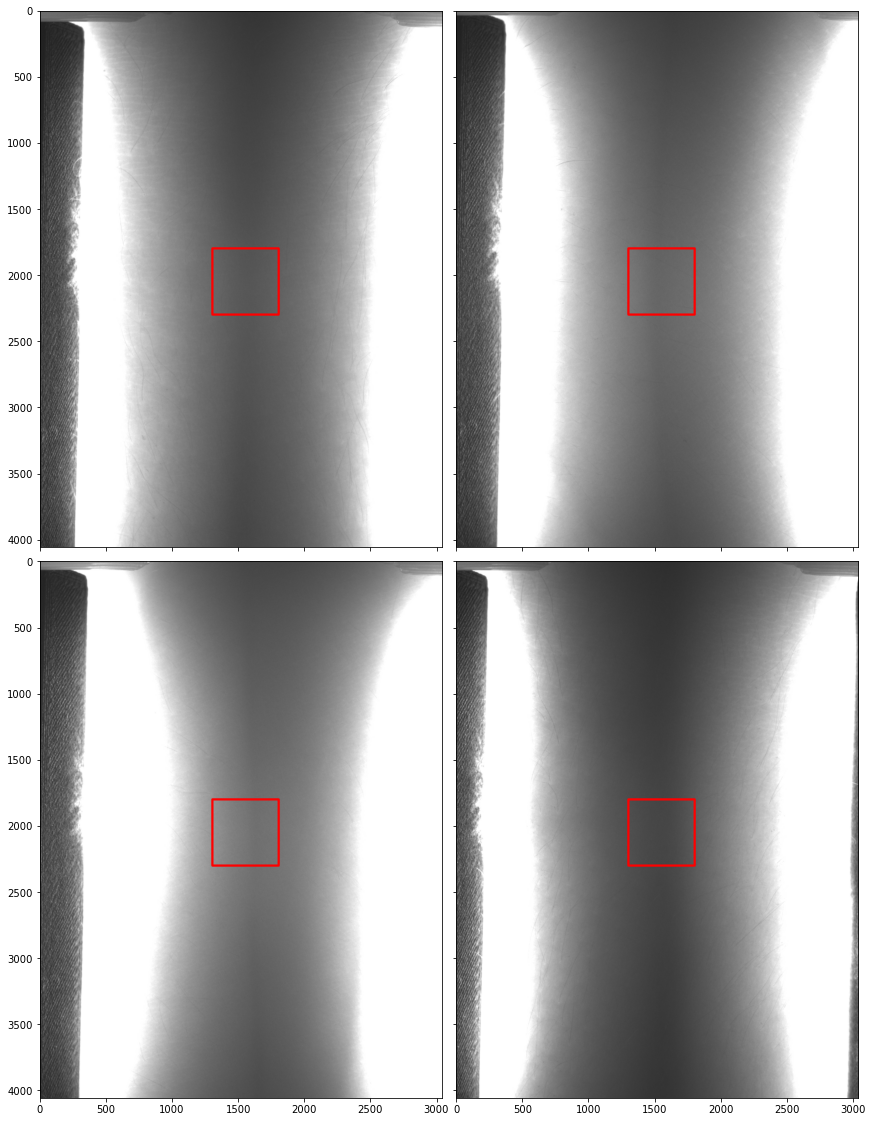

In [649]:
fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.2,  # pad between axes in inch.
                 )

for ax, im in zip(grid, images_to_show):
    ax.imshow(im)

plt.show()

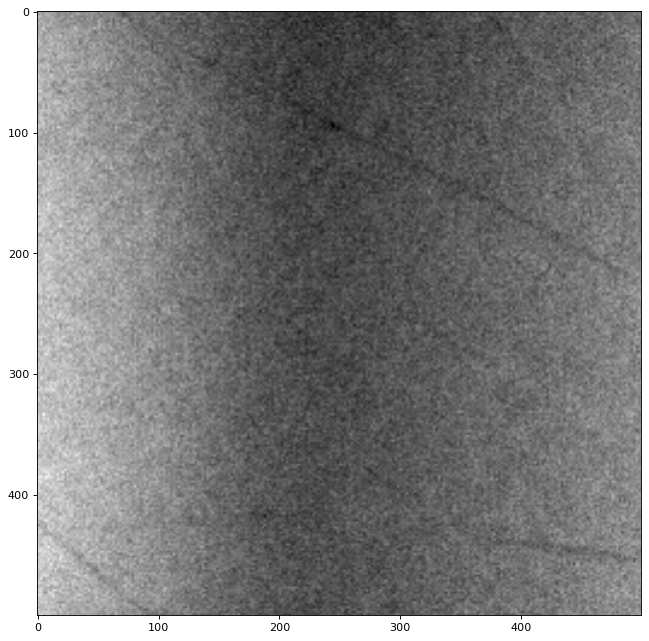

In [651]:
all_average = []
for shutter_speed_warped in all_warped:
    shutter_speed_average = []
    for warped_images in shutter_speed_warped:
        warped_average = []
        for warped in warped_images:
            average = np.mean(warped[0], axis=0)
            warped_average.append(average)
        shutter_speed_average.append(warped_average)
    all_average.append(shutter_speed_average)
all_average = np.array(all_average, dtype=object)

In [652]:
def sigmoid(x, L ,x0, k, A):
    y = L / (1 + np.exp(-k*(x-x0))) + A
    return (y)

In [727]:
fx = 1

all_data = []

for wavelength_index in range(all_average.shape[0]):
    shutters = []
    for shutter_speed_index in range(all_average.shape[1]):
        places = []
        for place_index in range(all_average.shape[2]):
            curve = all_average[wavelength_index][shutter_speed_index][place_index]
            curve = curve.astype("float")
            curve = cv2.blur(curve, (23,23)).flatten()
            
            dy = diff(curve)/fx
            dy[dy == -inf] = 0
            dy[dy == inf] = 0
            
            #dy = cv2.blur(dy, (23,23)).flatten()
            
            dx = np.array([x for x in range(len(dy))])
            p0 = [max(dy), np.median(dx),1,min(dy)]
            popt, pcov = curve_fit(sigmoid, dx, dy, p0, maxfev=500000)
            
            L = popt[0]
            k = popt[2]
            sharpness_coefficient = L*k
            
            places.append((curve, dy, popt, sharpness_coefficient))
        shutters.append(places)
    all_data.append(shutters)
all_data = np.array(all_data, dtype=object)

/var/folders/v6/b497thvs7zj8ph5s5ygb1__40000gn/T/ipykernel_41298/1662211312.py:2: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0))) + A
/Users/bastianpetersson/opt/anaconda3/envs/ML/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [728]:
all_data.shape

(4, 10, 4, 4)

In [762]:
curve, dy, sigmoid_parameters, sharpness_coefficient = all_data[0,9,0,:]

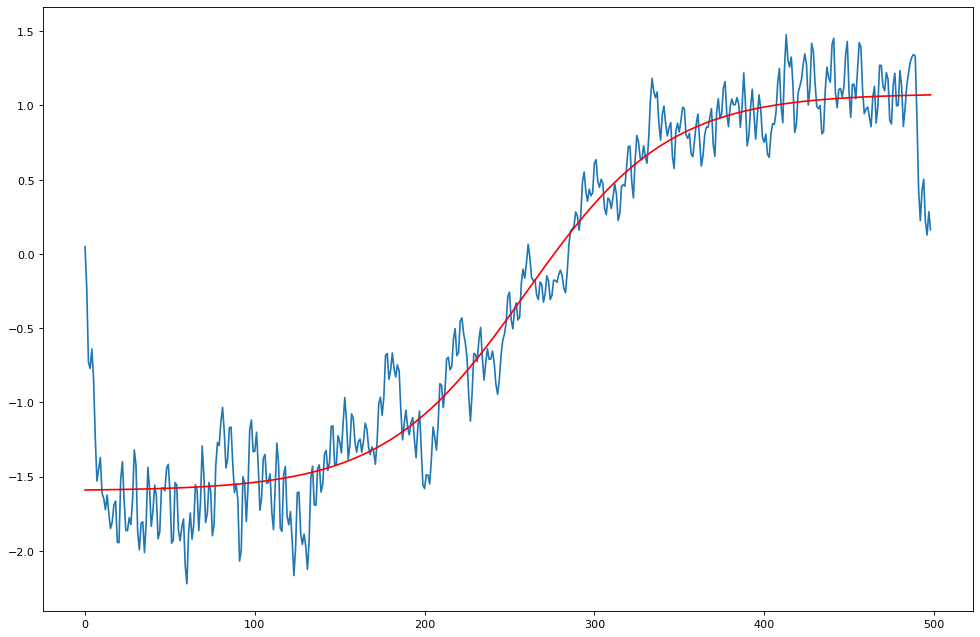

In [763]:
figure(figsize=(15, 10), dpi=80)
plt.plot(dy)
plt.plot(dx, sigmoid(dx, sigmoid_parameters[0], sigmoid_parameters[1], sigmoid_parameters[2], sigmoid_parameters[3]), color='red')

plt.show()

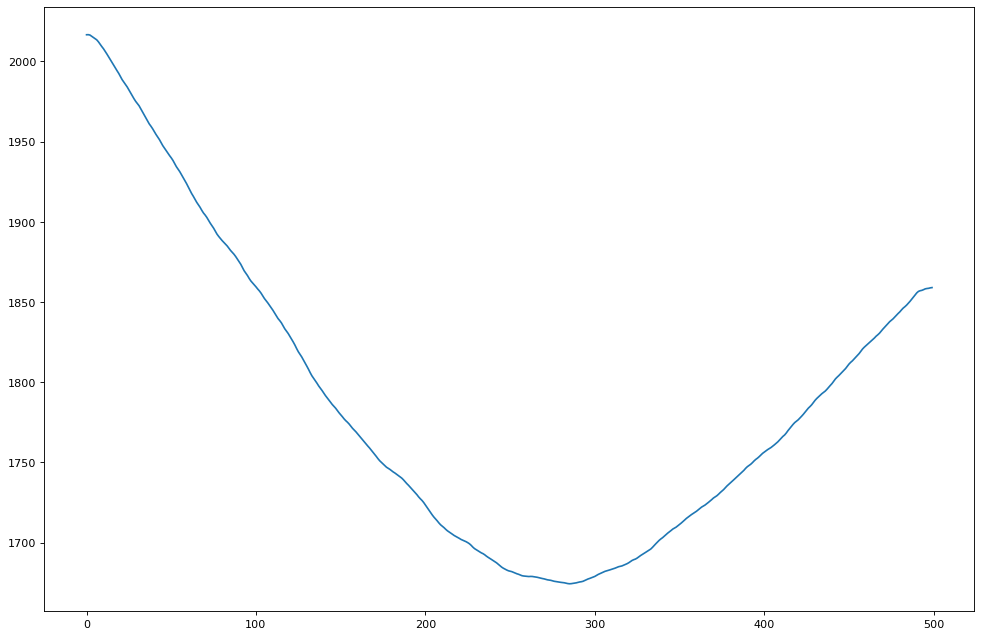

In [764]:
figure(figsize=(15, 10), dpi=80)
plt.plot(curve)

plt.show()

[0.1310346  0.08862077 0.05351495 0.0212254 ]


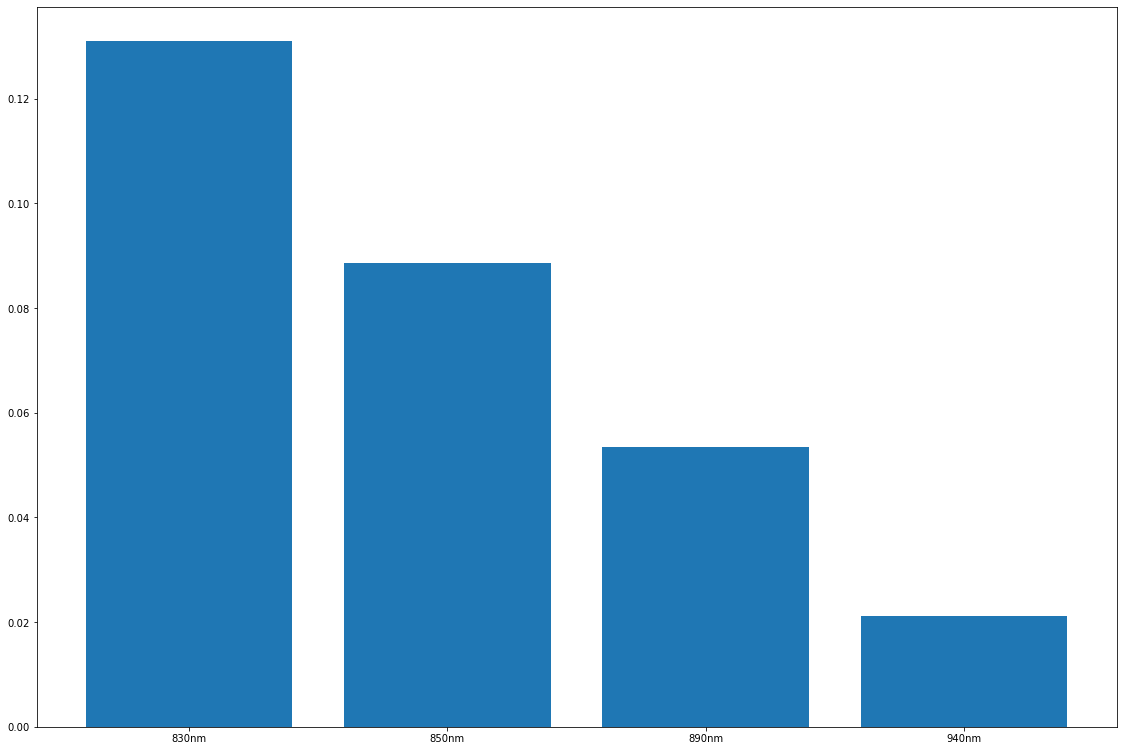

In [791]:
all_sharpness_coefficients = []
for i in range(4):
    sharpness_coefficients = []
    for j in range(4):
        curve, dy, sigmoid_parameters, sharpness_coefficient = all_data[i,9,j,:]
        sharpness_coefficients.append(sharpness_coefficient)
    all_sharpness_coefficients.append(sharpness_coefficients)
all_sharpness_coefficients = np.array(all_sharpness_coefficients)

sharpness_coefficients = all_sharpness_coefficients[:,3]
average_sharpness_coefficients = np.average(all_sharpness_coefficients, axis=1)
print(average_sharpness_coefficients)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_axes([0,0,1,1])
wavelengths = ['830nm', '850nm', '890nm', '940nm']
ax.bar(wavelengths, average_sharpness_coefficients)
plt.show()